In [1]:
import dask
import numpy as np
import plotly.express as px
import xarray as xr
from dask.distributed import Client
from plotly.subplots import make_subplots
from SALib import ProblemSpec
from seapopym.configuration.no_transport.parameter import ForcingParameters, ForcingUnit, KernelParameters

from seapopym_optimization import wrapper

User can modify this :


In [2]:
SAMPLE_NUMBER = 10_000

In [3]:
client = Client()
client

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65457 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:65457/status,
Dashboard: http://127.0.0.1:65457/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65458,Workers: 4
Dashboard: http://127.0.0.1:65457/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:65471,Total threads: 3
Dashboard: http://127.0.0.1:65475/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:65461,


Setup sensitivity analysis structure.


In [4]:
sp = ProblemSpec(
    {
        "names": [
            "inv_lambda_max",
            "inv_lambda_rate",
        ],
        "groups": None,
        "bounds": [
            [0, 500],
            [0, 1],
        ],
        "outputs": [
            "1 degree celcius",
            "5 degree celcius",
            "10 degree celcius",
            "15 degree celcius",
            "20 degree celcius",
        ],
    }
)

Create the cost function.


In [5]:
@dask.delayed
def cost_function(x: np.ndarray):
    inv_lambda_max, inv_lambda_rate = x.T
    mortality = lambda x, y, t: np.exp(-1 * (1 / (x * np.exp(-y * t))))
    return (
        mortality(inv_lambda_max, inv_lambda_rate, 1),
        mortality(inv_lambda_max, inv_lambda_rate, 5),
        mortality(inv_lambda_max, inv_lambda_rate, 10),
        mortality(inv_lambda_max, inv_lambda_rate, 15),
        mortality(inv_lambda_max, inv_lambda_rate, 20),
    )

# SOBOL SENSITIVITY ANALYSIS


In [6]:
param_values = sp.sample_sobol(SAMPLE_NUMBER)
res = [cost_function(param) for param in param_values.samples]
res = client.compute(res)
res = client.gather(res)
sp.set_results(np.asarray(res))

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Samples:
	2 parameters: ['inv_lambda_max', 'inv_lambda_rate']
	60000 samples
Outputs:
	5 outputs: ['1 degree celcius', '5 degree celcius', '10 degree celcius', '15 degree celcius', '20 degree celcius']
	60000 evaluations


In [7]:
sp.analyze_sobol()

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adm-lehodey/Documents/Workspace/Projects/Seap

Samples:
	2 parameters: ['inv_lambda_max', 'inv_lambda_rate']
	60000 samples
Outputs:
	5 outputs: ['1 degree celcius', '5 degree celcius', '10 degree celcius', '15 degree celcius', '20 degree celcius']
	60000 evaluations
Analysis:
1 degree celcius:
                       ST   ST_conf
inv_lambda_max   0.994723  0.030549
inv_lambda_rate  0.032410  0.005757:
                       S1   S1_conf
inv_lambda_max   0.970063  0.143543
inv_lambda_rate  0.005279  0.002884:
                                         S2   S2_conf
[inv_lambda_max, inv_lambda_rate]  0.030878  0.281461:
5 degree celcius:
                       ST   ST_conf
inv_lambda_max   0.571549  0.023006
inv_lambda_rate  0.583156  0.022925:
                      S1   S1_conf
inv_lambda_max   0.41425  0.034121
inv_lambda_rate  0.42989  0.022388:
                                         S2   S2_conf
[inv_lambda_max, inv_lambda_rate]  0.158783  0.054886:
10 degree celcius:
                       ST   ST_conf
inv_lambda_max   0.105346  

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adm-lehodey/Documents/Workspace/Projects/Seap

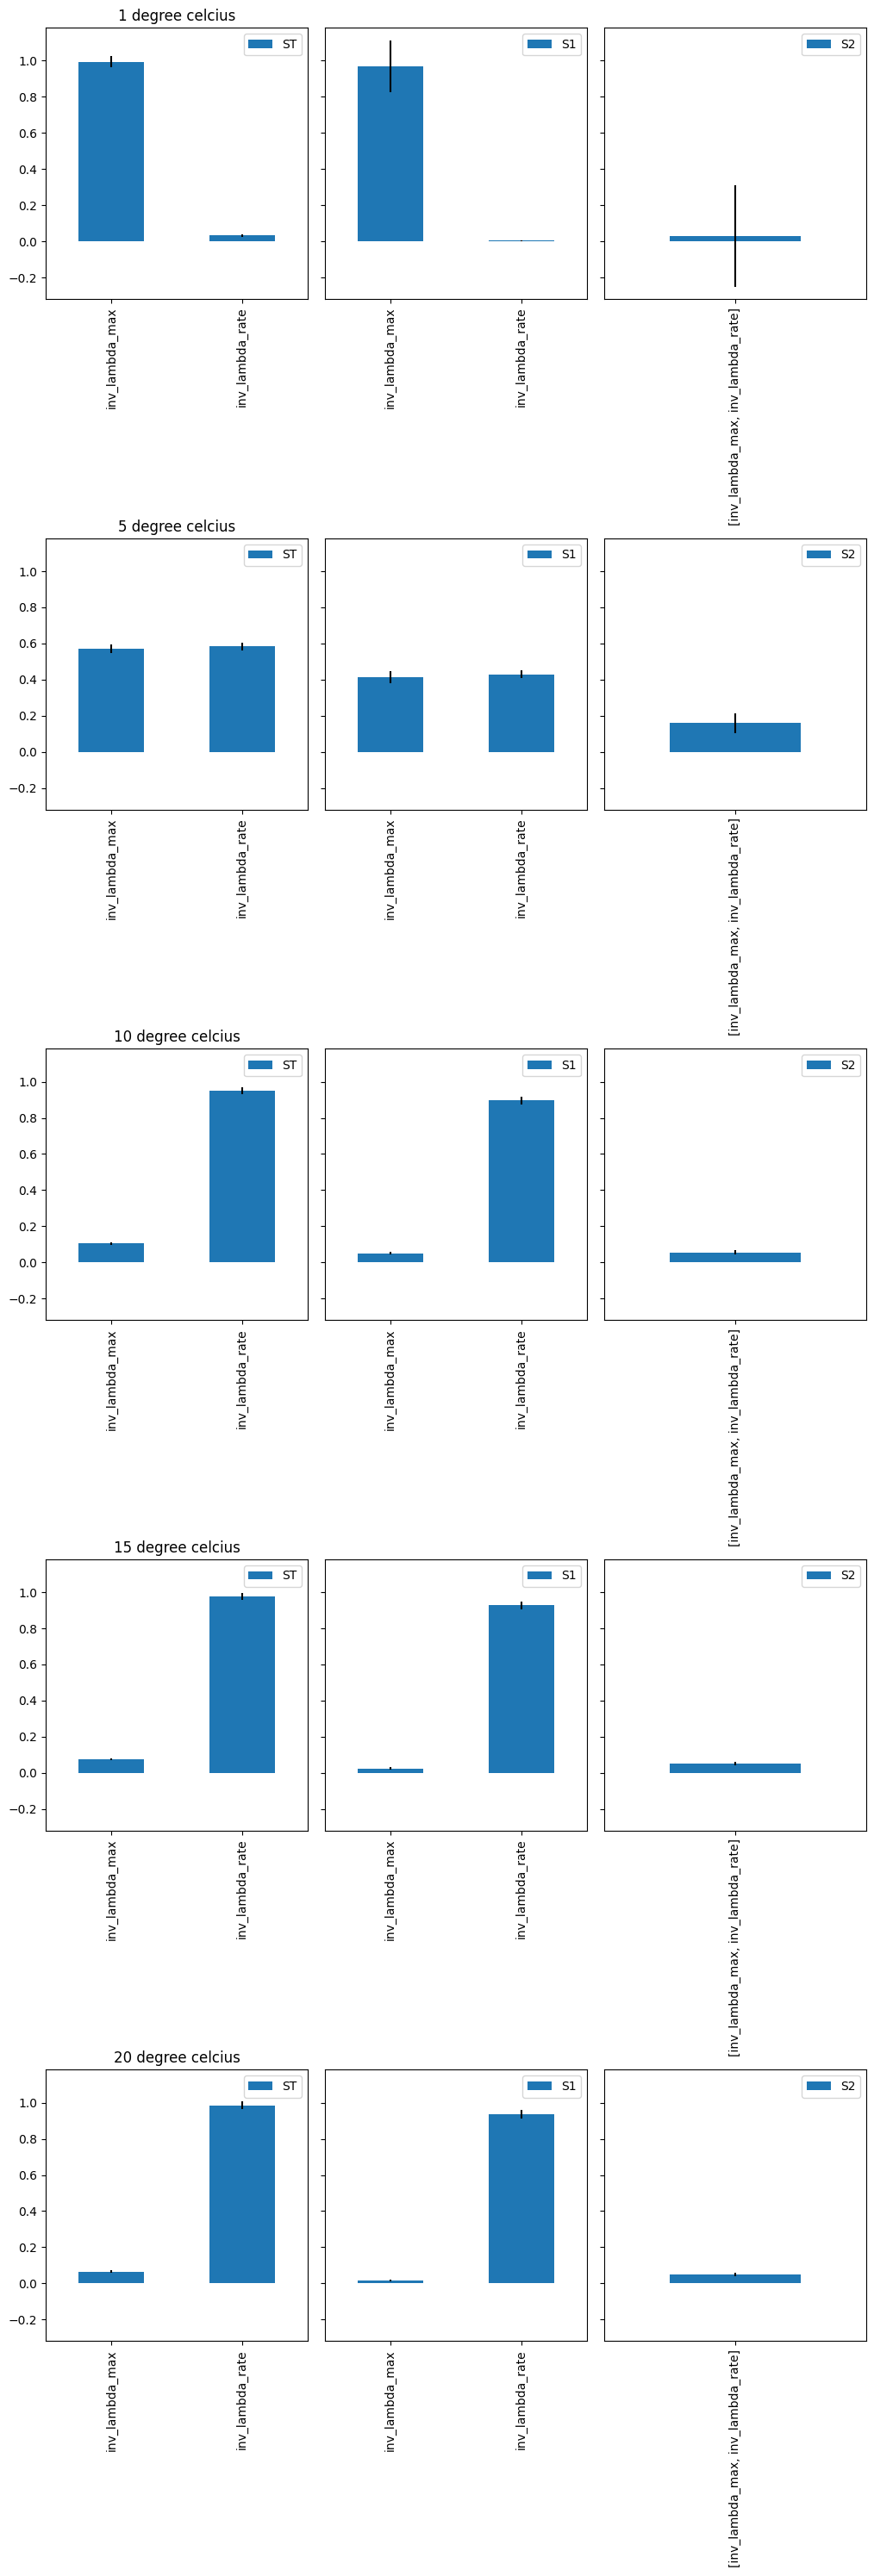

In [8]:
import matplotlib.pyplot as plt

axes = sp.plot()
fig = plt.gcf()  # get current figure
fig.set_size_inches(10, 30)
plt.tight_layout()